In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *

In [2]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
action_list = h36m_3d_world._data[subject].keys()
pose3d_s1_walking = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info_s1_walking = h36m_3d_world._data[subject][action]['cameras']
cam_param_s1_walking = get_cam_param(cam_info_s1_walking, subject, h36m_cam_param)

# camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']

# 3d trajectory
torso_trajectory = get_part_traj(pose3d_s1_walking, 'torso')
pelvis_trajectory = get_part_traj(pose3d_s1_walking, 'pelvis')
l_hip_trajectory = get_part_traj(pose3d_s1_walking, 'l_hip')
l_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'l_shoulder')
r_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'r_shoulder')
r_hip_trajectory = get_part_traj(pose3d_s1_walking, 'r_hip')
lower_line_trajectory = get_part_traj(pose3d_s1_walking, 'lower_line')

# World frame
world_frame = generate_world_frame()

==> Loading 3D data wrt World CS...


### Check rotation matrix and frame visualization

Rotation matrix 
- first col -> x-axis of rotated frame w.r.t ref frame
- second col -> y-axis of rotated frame w.r.t ref frame
- third col -> z-axis of rotated frame w.r.t ref frame
- first row -> x-axis of ref frame w.r.t rotated frame
- second row -> y-axis of ref frame w.r.t rotated frame
- third row -> z-axis of ref frame w.r.t rotated frame

[[ 2.22044605e-16  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  0.00000000e+00  2.22044605e-16]]


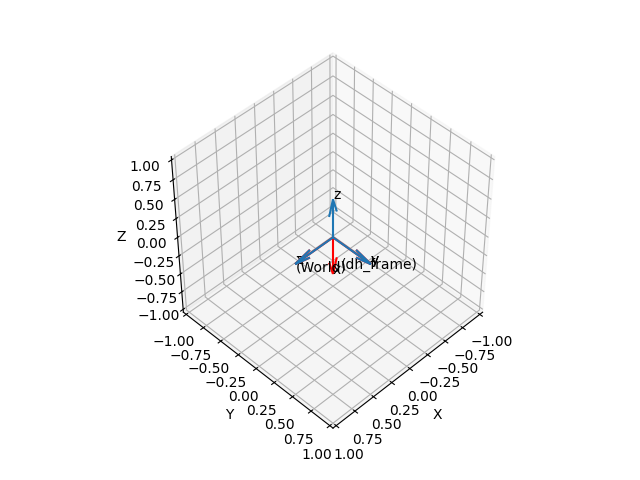

In [3]:
Rot_z_minus_90 = Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()
Rot_y_90 = Rotation.from_rotvec(np.pi/2 * np.array([0, 1, 0])).as_matrix()
print(Rot_y_90)
root_tf = np.eye(4)
root_tf[:3, :3] = Rot_y_90

root_frame = generate_vis_frame(root_tf[:3, 3], root_tf[:3, :3])

%matplotlib widget
fig = plt.figure(0)
fig.clear()
ax = axes_3d(fig, xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), view=(45, 45))
root_frame.draw3d(color='r')
generate_world_frame().draw3d()
plt.show()

[1 0 0] [ 2.22044605e-16  0.00000000e+00 -1.00000000e+00] [1. 0. 0.]


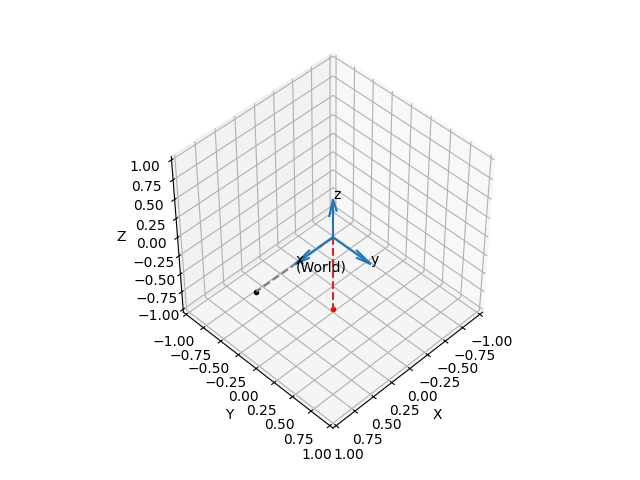

In [4]:
origin = np.array([0, 0, 0])
vec1 = np.array([1, 0, 0])
rotated_vec = Rot_y_90 @ vec1 
rotated_vec_wrt_rotated_frame = Rot_y_90.T @ rotated_vec

print(vec1, rotated_vec, Rot_y_90.T @ rotated_vec)


%matplotlib widget
fig = plt.figure(1)
fig.clear()
ax = axes_3d(fig, xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), view=(45, 45))
generate_world_frame().draw3d()
# vec1
ax.plot(vec1[0], vec1[1], vec1[2],  '.k') 
ax.plot(*np.c_[origin, vec1], color="tab:gray", ls='--') 
# rotated vec
ax.plot(rotated_vec[0], rotated_vec[1], rotated_vec[2],  '.r')
ax.plot(*np.c_[origin, rotated_vec], color="tab:red", ls='--')
plt.show()

### Simplified DH matrix for limb 

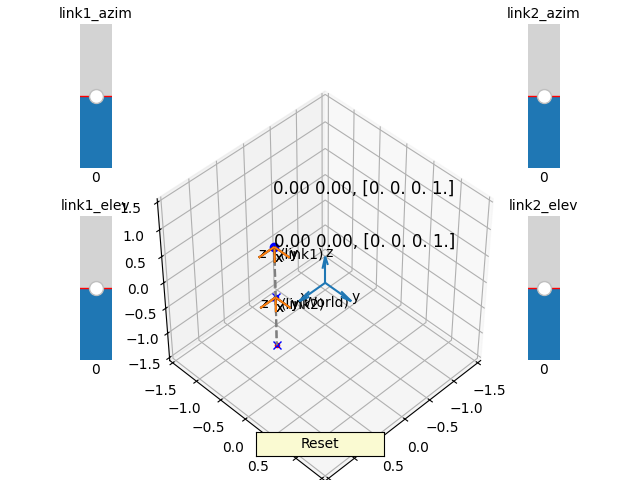

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider, Button
%matplotlib widget

# plot setting
fig11 = plt.figure(11)
fig11.clear()
ax1 = fig11.add_axes([0, 0, 1, 0.8], projection = '3d')
ax1.view_init(elev=45, azim=45)
ax1.set_aspect('equal', 'box')
world_frame = generate_world_frame()

# GUI setting
ax_link1_azim = fig11.add_axes([0.1, 0.65, 0.1, 0.3])
ax_link1_elev = fig11.add_axes([0.1, 0.25, 0.1, 0.3])
ax_link2_azim = fig11.add_axes([0.8, 0.65, 0.1, 0.3])
ax_link2_elev = fig11.add_axes([0.8, 0.25, 0.1, 0.3])
ax_reset = fig11.add_axes([0.4, 0.05, 0.2, 0.05])

link1_azim_init, link1_elev_init = 0, 0
link2_azim_init, link2_elev_init = 0, 0
link1_length, link2_length = 1, 1

s_link1_azim   = Slider(ax = ax_link1_azim, label = 'link1_azim', valmin = -180, valmax = 180, valinit = link1_azim_init, orientation="vertical")
s_link1_elev = Slider(ax = ax_link1_elev, label = 'link1_elev', valmin = -90, valmax = 90, valinit = link1_elev_init, orientation="vertical")
s_link2_azim   = Slider(ax = ax_link2_azim, label = 'link2_azim', valmin = -180, valmax = 180, valinit = link2_azim_init, orientation="vertical")
s_link2_elev = Slider(ax = ax_link2_elev, label = 'link2_elev', valmin = -90, valmax = 90, valinit = link2_elev_init, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

start_point = np.array([0, -1, 0])

# initial setting
origin = start_point
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
Rot_y_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 1, 0])).as_matrix()
Rot_y_90 = Rotation.from_rotvec(np.pi/2 * np.array([0, 1, 0])).as_matrix()
root_tf = np.eye(4)
root_tf[:3, :3] = Rot_y_90
root_tf[:3, 3] = origin

appendage = Appendage(link1_length, link2_length, link1_azim_init, link1_elev_init, link2_azim_init, link2_elev_init, degrees=True, root_tf=root_tf)

def update(val):
    # update two link model
    link1_azim = s_link1_azim.val
    link1_elev = s_link1_elev.val
    link2_azim = s_link2_azim.val
    link2_elev = s_link2_elev.val
    appendage.update_link_from_angle(link1_azim, link1_elev, link2_azim, link2_elev, degrees=True)
    
    ik_l1_azim, ik_l1_elev = calculate_azimuth_elevation(appendage.link1_vec, appendage.root_R, degrees=True)
    ik_l2_yaw, ik_l2_pitch = calculate_azimuth_elevation(appendage.link2_vec, appendage.link1_R, degrees=True)
    
    # plot setting
    azim = ax1.azim
    elev = ax1.elev
    ax1.cla()
    plt.sca(ax1)
    ax1.set_aspect('equal', 'box')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_zlim(-1.5, 1.5)
    ax1.view_init(elev, azim)

    # plot
    world_frame.draw3d() # world frame
    
    # draw frame
    #appendage.root_frame.draw3d(color='tab:red')
    #appendage.link1_frame.draw3d(color='tab:orange')
    #appendage.link2_frame.draw3d(color='tab:green')
    appendage.draw(ax1, draw_frame=True, scale=0.3, show_name=True, show_axis=True)
    
    # draw keypoint
    ax1.plot(appendage.link1_origin[0], appendage.link1_origin[1], appendage.link1_origin[2], 'ob')
    ax1.plot(appendage.link2_origin[0], appendage.link2_origin[1], appendage.link2_origin[2], 'xb')
    ax1.plot(appendage.terminal_origin[0], appendage.terminal_origin[1], appendage.terminal_origin[2], 'xb')
    
    # draw link
    ax1.plot(*np.c_[appendage.link1_origin, appendage.link2_origin], color="tab:gray", ls='--') 
    ax1.plot(*np.c_[appendage.link2_origin, appendage.terminal_origin], color="tab:gray", ls='--')

    # print IK results
    ax1.text(appendage.link1_origin[0], appendage.link1_origin[1], appendage.link1_origin[2]+1, f'{ik_l1_azim:.2f} {ik_l1_elev:.2f}, {Rotation.from_matrix(appendage.root_R.T @ appendage.link1_R).as_quat()}', fontsize=12) # link1 ik result
    ax1.text(appendage.link2_origin[0], appendage.link2_origin[1], appendage.link2_origin[2]+1, f'{ik_l2_yaw:.2f} {ik_l2_pitch:.2f}, {Rotation.from_matrix(appendage.link1_R.T @ appendage.link2_R).as_quat()}', fontsize=12) # link2 ik result
    #ax1.text(link2_origin[0], link2_origin[1], link2_origin[2]-2, '{:.2f} {:.2f} {:.2f}'.format(*list(link2_vec_wrt_link1)), fontsize=12) # link2 vec wrt link1 frame
    
        
def reset(event):
    s_link1_azim.reset()
    s_link1_elev.reset()
    s_link2_azim.reset()
    s_link2_elev.reset()
    
s_link1_azim.on_changed(update)
s_link1_elev.on_changed(update)
s_link2_azim.on_changed(update)
s_link2_elev.on_changed(update)
 
button.on_clicked(reset)
update(0)

plt.show()

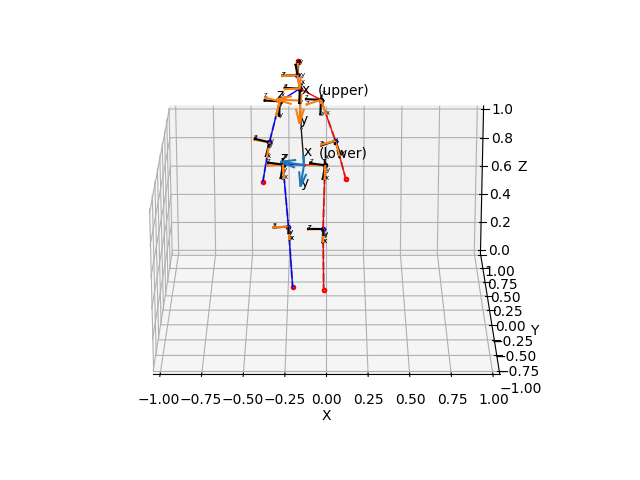

In [42]:
ref_pose = pose3d_s1_walking[0].copy()
dh_model = DHModel(ref_pose)
dh_model.update_dh_model_from_pose(ref_pose)

# # lower frame
# lower_origin, lower_frame_R = get_lower_torso_frame_from_pose(ref_pose)
# lower_frame = generate_vis_frame_from_R(lower_origin, lower_frame_R, name='lower')

# # upper frame
# upper_origin, upper_frame_R = get_upper_torso_frame_from_pose(ref_pose)
# upper_frame = generate_vis_frame_from_R(upper_origin, upper_frame_R, name='upper')

# plot
%matplotlib widget
fig = plt.figure(50)
fig.clear()
lim=1
ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-lim, lim), ylim=(-lim, lim), zlim=(0, lim), view=(20, -90))
dh_model.draw(ax, draw_frame=True, show_axis=True, scale=0.1, fontsize=5)
draw_3d_pose(ax, ref_pose)

plt.show()

### check angle continuity

In [14]:
for subject in h36m_3d_world._data.keys():
    for action in h36m_3d_world._data[subject]:
        print(subject, action)
        pose_3d_list = h36m_3d_world._data[subject][action]['positions']
        angles = get_limb_angle(pose_3d_list) 
        print(angles.shape)
        R_UPPER_LEG = angles[0::8][0]
        L_UPPER_LEG = angles[1::8][0]
        R_UPPER_ARM = angles[2::8][0]
        L_UPPER_ARM = angles[3::8][0]
        R_LOWER_LEG = angles[4::8][0]
        L_LOWER_LEG = angles[5::8][0]
        R_LOWER_ARM = angles[6::8][0]
        L_LOWER_ARM = angles[7::8][0]
        break
    break

S1 Waiting 1
torch.Size([8, 1440, 2])


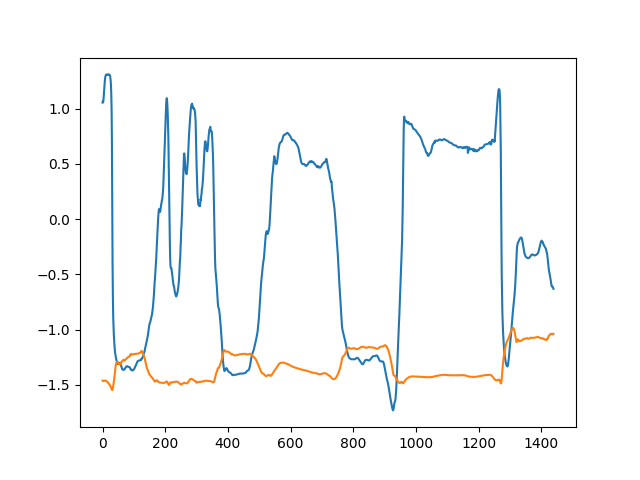

In [17]:
fig = plt.figure(51)
fig.clear()
ax = fig.add_subplot(111)
ax.plot(R_UPPER_LEG[:, 0], label='R_UPPER_LEG azim')
ax.plot(R_UPPER_LEG[:, 1], label='R_UPPER_LEG elev')
plt.show()

In [20]:
t = torch.rand([100, 3])

In [21]:
torch.where(t > 0.5, t, torch.zeros_like(t))

tensor([[0.8449, 0.6201, 0.0000],
        [0.6069, 0.0000, 0.0000],
        [0.8083, 0.0000, 0.0000],
        [0.6629, 0.5628, 0.6354],
        [0.5364, 0.0000, 0.0000],
        [0.9333, 0.6865, 0.0000],
        [0.6476, 0.0000, 0.7894],
        [0.7056, 0.0000, 0.0000],
        [0.5150, 0.0000, 0.0000],
        [0.0000, 0.6969, 0.7341],
        [0.7855, 0.0000, 0.9834],
        [0.0000, 0.0000, 0.0000],
        [0.7966, 0.0000, 0.5658],
        [0.0000, 0.0000, 0.7590],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.6406, 0.9814, 0.8726],
        [0.0000, 0.5365, 0.0000],
        [0.0000, 0.6012, 0.9315],
        [0.0000, 0.0000, 0.0000],
        [0.6195, 0.0000, 0.0000],
        [0.0000, 0.8265, 0.0000],
        [0.0000, 0.0000, 0.9241],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.5949, 0.0000],
        [0.7786, 0.0000, 0.0000],
        [0.6196, 0.0000, 0.9912],
        [0.5797, 0.7696, 0.0000],
        [0.8615, 0.9659, 0.0000],
        [0.583